In [0]:
## Word 2 Vec с нуля

In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 49


In [0]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We', 1)


In [0]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_ctx = self.embeddings(context).view((1, -1))
        score = torch.mm(embed_focus, torch.t(embed_ctx))
        log_probs = F.logsigmoid(score)
    
        return log_probs

In [0]:
embd_size = 100
learning_rate = 0.001
n_epoch = 30

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = []
    loss_fn = nn.MSELoss()
    model = SkipGram(vocab_size, embd_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in skipgram_train:
            in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
            out_w_var = Variable(torch.LongTensor([w2i[out_w]]))
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        losses.append(total_loss)
    return model, losses
    
cbow_model, cbow_losses = train_cbow()
sg_model, sg_losses = train_skipgram()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


SkipGram(
  (embeddings): Embedding(49, 100)
)


In [0]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted.item()]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w, target in test_data:
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

        model.zero_grad()
        log_probs = model(in_w_var, out_w_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted = predicted.item()
        if predicted == target:
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===
predicted: about
label    : about
predicted: to
label    : to
predicted: study
label    : study
predicted: the
label    : the
predicted: idea
label    : idea
predicted: of
label    : of
predicted: a
label    : a
predicted: computational
label    : computational
predicted: process.
label    : process.
predicted: Computational
label    : Computational
predicted: processes
label    : processes
predicted: are
label    : are
predicted: abstract
label    : abstract
predicted: beings
label    : beings
predicted: that
label    : that
predicted: inhabit
label    : inhabit
predicted: computers.
label    : computers.
predicted: As
label    : As
predicted: they
label    : they
predicted: to
label    : evolve,
predicted: processes
label    : processes
predicted: manipulate
label    : manipulate
predicted: other
label    : other
predicted: abstract
label    : abstract
predicted: things
label    : things
predicted: called
label    : called
predicted: data.
label    : data.
predicted:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


<Figure size 432x288 with 0 Axes>

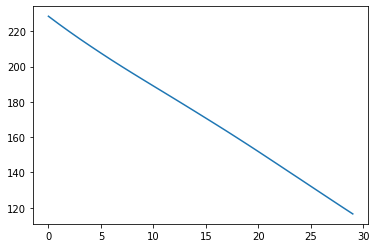

<Figure size 432x288 with 0 Axes>

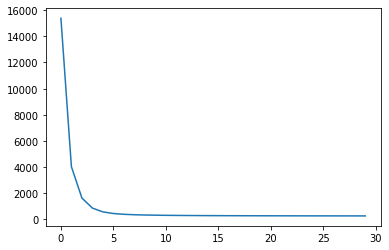

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')

In [0]:
## GenSim с нуля

In [0]:
from gensim.models import Word2Vec
# define training data
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
			['this', 'is', 'the', 'second', 'sentence'],
			['yet', 'another', 'sentence'],
			['one', 'more', 'sentence'],
			['and', 'the', 'final', 'sentence']]
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)


Word2Vec(vocab=14, size=100, alpha=0.025)
['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec', 'second', 'yet', 'another', 'one', 'more', 'and', 'final']
[-4.0710852e-03 -1.6556672e-03 -1.6523399e-03 -4.4876351e-03
 -4.3025655e-03  1.5507800e-03 -3.5333410e-03 -4.8908782e-03
  2.4472454e-03  2.0405124e-03  2.9907813e-03 -1.5484554e-03
  4.6143476e-03  4.8002265e-03 -2.8373054e-03  1.8123138e-03
 -7.6161168e-04 -1.9571795e-03  4.4127665e-03  3.2450494e-03
 -1.0949742e-03  4.3865031e-04  1.9850584e-03 -4.3804250e-03
  1.1893313e-03  3.5652064e-03 -2.3261956e-03 -1.6517923e-03
 -4.2073522e-03 -2.4813288e-03 -9.5609349e-04 -4.0180609e-03
 -1.0546945e-03 -2.6348031e-03 -5.9060566e-04 -1.0844733e-03
 -3.1762891e-03  2.8340295e-03 -8.4288075e-04  7.2759250e-04
  1.3812257e-04  3.8169411e-03  4.3788101e-03 -2.8238157e-03
 -6.2946987e-04 -4.7648437e-03 -1.3636609e-03  1.5284908e-03
 -1.7171596e-03  2.6916326e-03  1.7347097e-03 -2.7952301e-03
 -5.8173714e-04  3.8392681e-03 -4.5809955e-0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
X = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

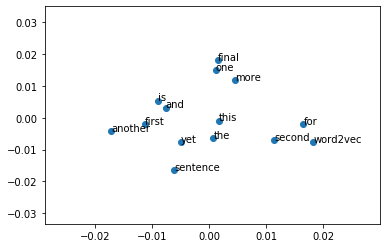

In [0]:
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [0]:
## Gensim готовый

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2019-12-17 15:19:56--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.85.149
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.85.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  17.1MB/s    in 95s     

2019-12-17 15:21:31 (16.6 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
from gensim.models import KeyedVectors
# load the google word2vec model
filename = 'GoogleNews-vectors-negative300.bin.gz'
model = KeyedVectors.load_word2vec_format(filename, binary=True)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
print(result)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321243286133), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.518113374710083), ('sultan', 0.5098593235015869), ('monarchy', 0.5087411999702454)]


## Домашнее задание
1. Скачать датасет с фразами симпосонов - https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data
2. Обучить word2vec на фразах персонажей
3. Построить word cloud по самым частотным словам (top 1000)
4. Найти самые близкие слова для:
    * homer - marge + bart
    * bart - lisa + school
    * marge - homer + home
    * 
5. классификатор чья речь - Барт/Лиза

In [1]:
!git clone https://github.com/sujanjoejacob/Text-mining-with-Simpsons-Data.git

Cloning into 'Text-mining-with-Simpsons-Data'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21
Unpacking objects: 100% (21/21), done.


In [2]:
!unzip ./Text-mining-with-Simpsons-Data/simpsons_script_lines.csv.zip -d script_lines

Archive:  ./Text-mining-with-Simpsons-Data/simpsons_script_lines.csv.zip
  inflating: script_lines/simpsons_script_lines.csv  


In [3]:
!head -n 10 ./script_lines/simpsons_script_lines.csv

id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
9549,32,209,"Miss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",848000,true,464,3,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.",no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it,31
9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
9551,32,211,Miss Hoover: I don't know. Although I'd sure like to talk to him. He didn't touch my lesson plan. Wh

In [47]:
import pandas as pd
df = pd.read_csv('./script_lines/simpsons_script_lines.csv',quoting=1,error_bad_lines=False)

b'Skipping line 8084: expected 13 fields, saw 20\nSkipping line 52607: expected 13 fields, saw 21\nSkipping line 59910: expected 13 fields, saw 21\n'
b'Skipping line 71801: expected 13 fields, saw 20\nSkipping line 73539: expected 13 fields, saw 21\nSkipping line 77230: expected 13 fields, saw 21\nSkipping line 78953: expected 13 fields, saw 21\nSkipping line 81138: expected 13 fields, saw 20\nSkipping line 86746: expected 13 fields, saw 22\nSkipping line 101154: expected 13 fields, saw 21\nSkipping line 115438: expected 13 fields, saw 20\nSkipping line 117573: expected 13 fields, saw 22\nSkipping line 130610: expected 13 fields, saw 22\n'
b'Skipping line 152970: expected 13 fields, saw 22\nSkipping line 153017: expected 13 fields, saw 20\nSkipping line 153018: expected 13 fields, saw 30\nSkipping line 154080: expected 13 fields, saw 20\nSkipping line 154082: expected 13 fields, saw 20\nSkipping line 154084: expected 13 fields, saw 20\nSkipping line 154086: expected 13 fields, saw 20\n

In [48]:
df.head()

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31.0
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3.0
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22.0
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5.0
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33.0


In [0]:
from gensim.models import Word2Vec
import re

# define training data
#with open('./script_lines/simpsons_script_lines.csv') as f:
#  sentences = [re.findall("[a-zA-Z]+", s) for s in f.readlines()[1:]]
sentences = [re.findall("[a-zA-Z]+", s) for s in df.dropna(subset=['normalized_text'])['normalized_text'].values]

In [7]:
sentences

[['no',
  'actually',
  'it',
  'was',
  'a',
  'little',
  'of',
  'both',
  'sometimes',
  'when',
  'a',
  'disease',
  'is',
  'in',
  'all',
  'the',
  'magazines',
  'and',
  'all',
  'the',
  'news',
  'shows',
  'its',
  'only',
  'natural',
  'that',
  'you',
  'think',
  'you',
  'have',
  'it'],
 ['wheres', 'mr', 'bergstrom'],
 ['i',
  'dont',
  'know',
  'although',
  'id',
  'sure',
  'like',
  'to',
  'talk',
  'to',
  'him',
  'he',
  'didnt',
  'touch',
  'my',
  'lesson',
  'plan',
  'what',
  'did',
  'he',
  'teach',
  'you'],
 ['that', 'life', 'is', 'worth', 'living'],
 ['the',
  'polls',
  'will',
  'be',
  'open',
  'from',
  'now',
  'until',
  'the',
  'end',
  'of',
  'recess',
  'now',
  'just',
  'in',
  'case',
  'any',
  'of',
  'you',
  'have',
  'decided',
  'to',
  'put',
  'any',
  'thought',
  'into',
  'this',
  'well',
  'have',
  'our',
  'final',
  'statements',
  'martin'],
 ['i', 'dont', 'think', 'theres', 'anything', 'left', 'to', 'say'],
 ['bar

In [8]:
# train model
model = Word2Vec(sentences, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)
X = model[model.wv.vocab]

Word2Vec(vocab=40281, size=100, alpha=0.025)
['no', 'actually', 'it', 'was', 'a', 'little', 'of', 'both', 'sometimes', 'when', 'disease', 'is', 'in', 'all', 'the', 'magazines', 'and', 'news', 'shows', 'its', 'only', 'natural', 'that', 'you', 'think', 'have', 'wheres', 'mr', 'bergstrom', 'i', 'dont', 'know', 'although', 'id', 'sure', 'like', 'to', 'talk', 'him', 'he', 'didnt', 'touch', 'my', 'lesson', 'plan', 'what', 'did', 'teach', 'life', 'worth', 'living', 'polls', 'will', 'be', 'open', 'from', 'now', 'until', 'end', 'recess', 'just', 'case', 'any', 'decided', 'put', 'thought', 'into', 'this', 'well', 'our', 'final', 'statements', 'martin', 'theres', 'anything', 'left', 'say', 'bart', 'victory', 'party', 'under', 'slide', 'hey', 'moved', 'out', 'morning', 'must', 'new', 'job', 'took', 'his', 'copernicus', 'costume', 'do', 'where', 'could', 'find', 'hes', 'taking', 'next', 'train', 'capital', 'city', 'how', 'traditional', 'yet', 'environmentally', 'sound', 'yes', 'been', 'backbone', '

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Word2Vec(vocab=40281, size=100, alpha=0.025)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
top_words = [w[0] for w in sorted([(w,model.wv.vocab[w].count) for w in model.wv.vocab], key=lambda x: -x[1])[:1000]]
X = model[top_words]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X)

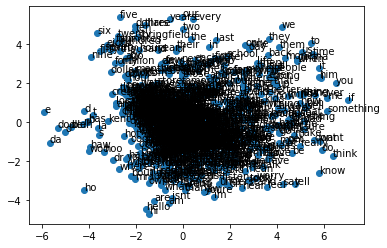

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(top_words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [27]:
'''homer - marge + bart
bart - lisa + school
marge - homer + hom'''

print(f"homer - marge + bart = {model.most_similar(positive=['homer', 'bart'], negative=['marge'], topn=3)}")
print(f"bart - lisa + school = {model.most_similar(positive=['bart', 'school'], negative=['lisa'], topn=3)}")
print(f"marge - homer + hom = {model.most_similar(positive=['marge', 'hom'], negative=['homer'], topn=3)}")

homer - marge + bart = [('lisa', 0.8708339929580688), ('grampa', 0.7119808197021484), ('milhouse', 0.6787078380584717)]
bart - lisa + school = [('house', 0.7892946004867554), ('game', 0.7722834348678589), ('once', 0.7701107263565063)]
marge - homer + hom = [('ugh', 0.840978741645813), ('momento', 0.8284861445426941), ('flynn', 0.8274775147438049)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


## Check TOP 10 words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


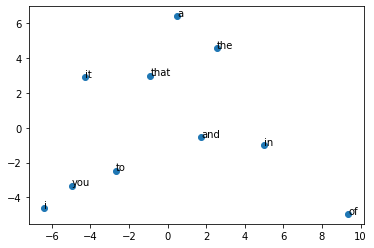

In [28]:
top_words = [w[0] for w in sorted([(w,model.wv.vocab[w].count) for w in model.wv.vocab], key=lambda x: -x[1])[:10]]
X = model[top_words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(top_words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

# Classification

In [0]:
df = df[df['raw_character_text'].isin(('Lisa Simpson', 'Bart Simpson'))]
df = df.dropna(subset=['normalized_text'])
df['normalized_text'] = df['normalized_text'].apply(lambda x: re.findall("[a-zA-Z]+", x))
df = df.dropna(subset=['normalized_text'])

In [50]:
df.shape

(23775, 13)

In [51]:
# train model
model = Word2Vec(df['normalized_text'].tolist(), min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words)
# access vector for one word
print(model['sentence'])
# save model
model.save('model.bin')
# load model
new_model = Word2Vec.load('model.bin')
print(new_model)
X = model[model.wv.vocab]

Word2Vec(vocab=14874, size=100, alpha=0.025)
['wheres', 'mr', 'bergstrom', 'that', 'life', 'is', 'worth', 'living', 'victory', 'party', 'under', 'the', 'slide', 'do', 'you', 'know', 'where', 'i', 'could', 'find', 'him', 'train', 'how', 'like', 'traditional', 'yet', 'environmentally', 'sound', 'see', 'he', 'touched', 'too', 'hey', 'thanks', 'for', 'your', 'vote', 'man', 'well', 'got', 'right', 'girls', 'dont', 'sweat', 'it', 'just', 'so', 'long', 'as', 'a', 'couple', 'of', 'people', 'did', 'milhouse', 'lewis', 'somebody', 'must', 'have', 'voted', 'uh', 'oh', 'demand', 'recount', 'no', 'lisa', 'indeed', 'mean', 'were', 'going', 'to', 'leave', 'cant', 'go', 'youre', 'best', 'teacher', 'ill', 'ever', 'please', 'but', 'need', 'understand', 'im', 'miss', 'thank', 'guess', 'this', 'mind', 'run', 'alongside', 'speeds', 'from', 'my', 'nothing', 'left', 'today', 'hes', 'gone', 'forever', 'didnt', 'think', 'youd', 'glad', 'not', 'crying', 'because', 'would', 'hate', 'what', 'about', 'say', 'based

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Word2Vec(vocab=14874, size=100, alpha=0.025)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
df['len'] = df['normalized_text'].apply(lambda x: len(x))

In [0]:
df = df[df['len']>0]

In [81]:
len(X_train[0][0])

100

In [90]:
X = [model[w] for w in df['normalized_text'].tolist()]
y = df['raw_character_text'].tolist()

MAX_LEN = 20
BATCH_SIZE = 128

import torch
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()
y_train = l.fit_transform(y_train)
y_test = l.transform(y_test)

train_data = torch.zeros((len(X_train), MAX_LEN), dtype=int)
test_data = torch.zeros((len(X_test), MAX_LEN), dtype=int)

for i in range(len(X_train)):
  for j, w in enumerate(X_train[i]):
    if j >= MAX_LEN:
      break
    train_data[i, j] = torch.tensor(np.argmax(w))
for i in range(len(X_test)):
  for j, w in enumerate(X_test[i]):
    if j >= MAX_LEN:
      break
    test_data[i, j] = torch.tensor(np.argmax(w))

train_dataset = torch.utils.data.TensorDataset(train_data, torch.LongTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(test_data, torch.LongTensor(y_test))
train = torch.utils.data.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test = torch.utils.data.DataLoader(test_dataset, BATCH_SIZE, shuffle=False)
dev = torch.device('cuda')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
from torch import nn
import time

In [0]:
def validate_acc(model, dataset, dev):
  loss = nn.CrossEntropyLoss(reduction='sum')
  loss_acc, passed, correct = 0., 0, 0
  for X, y in dataset:
    X = X.to(dev)
    y = y.to(dev)

    output = model(X)
    l = loss(output, y)

    loss_acc += l.item()
    correct += (output.argmax(dim=1) == y).sum().item()
    passed += len(y)

  return loss_acc / passed, correct / passed

def train_model(model, train_dl, test_dl, trainer, dev, num_epochs=25):
  loss = nn.CrossEntropyLoss(reduction='sum')
  for ep in range(num_epochs):
    ep_start, tloss_acc, tpassed, tcorrect = time.time(), 0., 0, 0
    for X, y in train_dl:
      X, y = X.to(dev), y.to(dev)
      trainer.zero_grad()

      output = model(X)
      l = loss(output, y)
      l.backward()
      trainer.step()

      tloss_acc += l.item()
      tcorrect += (output.argmax(dim=1) == y).sum().item()
      tpassed += len(y)
    
    test_loss, test_acc = validate_acc(model, test_dl, dev)

    print('Epoch {}. Taked {:.3f} sec. Train loss: {:.3f}, Train acc {:.3f}, Test  Loss {:.3f}, Test Acc {:.3f}'.format(
        ep, time.time() - ep_start, tloss_acc / tpassed, tcorrect / tpassed, test_loss, test_acc
    ))

class UberModel(nn.Module):
  def __init__(self, dict_size, embed_size, num_hiddens, num_classes):
    super().__init__()

    self.num_hiddens = num_hiddens
    self.embed = nn.Embedding(dict_size, embed_size)
    self.rnn = nn.GRU(embed_size, num_hiddens, batch_first=True, num_layers=2)
    self.hidden = nn.Linear(num_hiddens, num_classes)

  def forward(self, X):
    output = self.embed(X)
    y, s = self.rnn(output)
    h = self.hidden(s[0])
    return h

In [95]:
model = UberModel(len(words), 150, 128, 2).to(dev)
trainer = torch.optim.SGD(model.parameters(), lr=0.01)
train_model(model, train, test, trainer, dev)

Epoch 0. Taked 0.786 sec. Train loss: 13.093, Train acc 0.501, Test  Loss 11.393, Test Acc 0.450
Epoch 1. Taked 0.615 sec. Train loss: 9.994, Train acc 0.504, Test  Loss 1.671, Test Acc 0.547
Epoch 2. Taked 0.614 sec. Train loss: 9.774, Train acc 0.505, Test  Loss 3.062, Test Acc 0.551
Epoch 3. Taked 0.614 sec. Train loss: 8.539, Train acc 0.513, Test  Loss 2.115, Test Acc 0.551
Epoch 4. Taked 0.610 sec. Train loss: 8.239, Train acc 0.505, Test  Loss 1.387, Test Acc 0.483
Epoch 5. Taked 0.607 sec. Train loss: 8.022, Train acc 0.503, Test  Loss 7.071, Test Acc 0.552
Epoch 6. Taked 0.605 sec. Train loss: 7.193, Train acc 0.508, Test  Loss 7.643, Test Acc 0.552
Epoch 7. Taked 0.613 sec. Train loss: 6.844, Train acc 0.507, Test  Loss 5.209, Test Acc 0.448
Epoch 8. Taked 0.642 sec. Train loss: 6.859, Train acc 0.503, Test  Loss 3.289, Test Acc 0.552
Epoch 9. Taked 0.673 sec. Train loss: 6.276, Train acc 0.505, Test  Loss 1.817, Test Acc 0.449
Epoch 10. Taked 0.615 sec. Train loss: 5.659, Tr

In [100]:
model = UberModel(len(words), 300, 256, 2).to(dev)
trainer = torch.optim.SGD(model.parameters(), lr=0.005)
train_model(model, train, test, trainer, dev)

Epoch 0. Taked 0.844 sec. Train loss: 9.163, Train acc 0.499, Test  Loss 2.713, Test Acc 0.448
Epoch 1. Taked 0.826 sec. Train loss: 4.566, Train acc 0.502, Test  Loss 1.818, Test Acc 0.552
Epoch 2. Taked 0.820 sec. Train loss: 4.093, Train acc 0.502, Test  Loss 1.310, Test Acc 0.550
Epoch 3. Taked 0.824 sec. Train loss: 3.531, Train acc 0.508, Test  Loss 0.963, Test Acc 0.529
Epoch 4. Taked 0.830 sec. Train loss: 2.885, Train acc 0.497, Test  Loss 2.051, Test Acc 0.554
Epoch 5. Taked 0.825 sec. Train loss: 2.598, Train acc 0.504, Test  Loss 1.503, Test Acc 0.549
Epoch 6. Taked 0.824 sec. Train loss: 2.427, Train acc 0.504, Test  Loss 0.759, Test Acc 0.459
Epoch 7. Taked 0.825 sec. Train loss: 2.471, Train acc 0.504, Test  Loss 0.747, Test Acc 0.480
Epoch 8. Taked 0.826 sec. Train loss: 2.213, Train acc 0.511, Test  Loss 1.712, Test Acc 0.551
Epoch 9. Taked 0.819 sec. Train loss: 2.137, Train acc 0.509, Test  Loss 1.450, Test Acc 0.551
Epoch 10. Taked 0.830 sec. Train loss: 2.082, Trai